In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 28

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 800)               34400     
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               320400    
                                                                 
 dense_2 (Dense)             (None, 28)                11228     
                                                                 
Total params: 366028 (1.40 MB)
Trainable params: 366028 (1.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


562/562 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.7023
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
562/562 [==============================] - 5s 8ms/step - loss: 0.8648 - accuracy: 0.7023 - val_loss: 0.2419 - val_accuracy: 0.9436
Epoch 2/1000
 26/562 [>.............................] - ETA: 3s - loss: 0.5067 - accuracy: 0.8173

C:\Users\tanta\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


556/562 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.8519
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
562/562 [==============================] - 4s 7ms/step - loss: 0.4173 - accuracy: 0.8522 - val_loss: 0.1379 - val_accuracy: 0.9712
Epoch 3/1000
559/562 [============================>.] - ETA: 0s - loss: 0.2778 - accuracy: 0.9051
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
562/562 [==============================] - 4s 8ms/step - loss: 0.2776 - accuracy: 0.9052 - val_loss: 0.0946 - val_accuracy: 0.9881
Epoch 4/1000
557/562 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9275
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
562/562 [==============================] - 4s 8ms/step - loss: 0.2161 - accuracy: 0.9276 - val_loss: 0.0839 - val_accuracy: 0.9772
Epoch 5/1000
558/562 [============================>.] - ETA: 0s - loss: 0.1740 - accuracy: 0.9423


In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

188/188 [==============================] - 0s 2ms/step - loss: 0.0742 - accuracy: 0.9719


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 87ms/step
[2.28590105e-16 7.59918864e-11 5.64342084e-09 2.11135959e-13
 1.18135458e-11 5.44848092e-07 5.77990079e-07 9.99482632e-01
 4.33514098e-04 6.27702757e-05 1.78642240e-11 1.67366077e-09
 9.15524817e-13 4.16801456e-08 7.54168354e-07 1.47037382e-11
 1.72521666e-07 1.15643886e-07 1.32586721e-17 3.97968364e-07
 2.51657480e-11 7.60655566e-11 7.74265721e-11 1.35277423e-12
 2.39150541e-15 7.17166915e-18 1.83646607e-05 3.23662483e-08]
7


# 混同行列

749/749 [==============================] - 1s 1ms/step


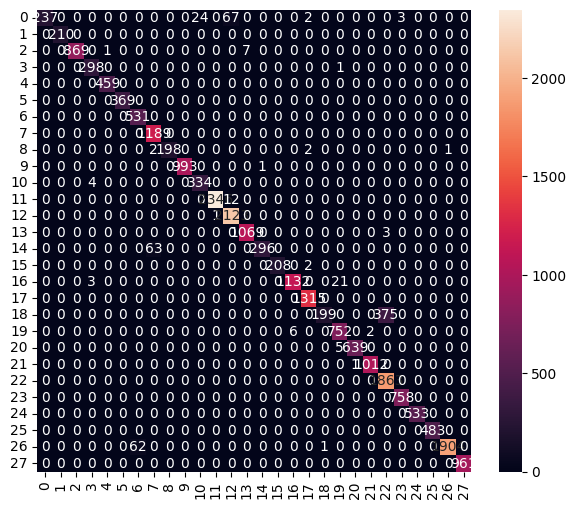

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       333
           1       1.00      1.00      1.00       210
           2       1.00      0.99      1.00       877
           3       0.98      1.00      0.99       299
           4       1.00      1.00      1.00       459
           5       1.00      1.00      1.00       369
           6       0.90      1.00      0.94       531
           7       0.95      1.00      0.97      1189
           8       1.00      0.98      0.99       203
           9       1.00      1.00      1.00       994
          10       0.93      0.99      0.96       338
          11       1.00      0.99      1.00      2358
          12       0.96      1.00      0.98      2124
          13       0.99      1.00      1.00      1072
          14       1.00      0.82      0.90       359
          15       1.00      0.99      1.00       210
          16       0.99      0.98      0.99      1156
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

C:\Users\tanta\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmptj8jn14k\assets


INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmptj8jn14k\assets


371976

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.50418324e-16 8.92508775e-11 6.56511823e-09 3.43847048e-13
 1.50088639e-11 5.18106901e-07 7.72276735e-07 9.99460638e-01
 4.45571262e-04 7.14667112e-05 2.28543330e-11 2.22805663e-09
 1.05824702e-12 5.06480831e-08 8.83212635e-07 1.94708381e-11
 1.62957164e-07 1.23928118e-07 1.81848660e-17 5.78866548e-07
 3.09391367e-11 1.07145376e-10 9.40130820e-11 1.76938976e-12
 3.57654495e-15 9.39331828e-18 1.92095067e-05 3.90266663e-08]
7
